In [23]:
import os
import re

from tqdm import tqdm
from natsort import natsorted

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import cv2
from PIL import Image, ImageDraw, ImageFont

import pdfplumber
# import pytesseract
import easyocr
# from langchain_community.document_loaders import (
#     UnstructuredPDFLoader,
#     PyMuPDFLoader,
# )

import random
import torch
seed = 42
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

import warnings
warnings.filterwarnings('ignore')

In [2]:
data_path = "./data/card"
data_list = [data_path + "/" + path for path in natsorted(os.listdir(data_path))]

# PDF Crop 테스트

In [3]:
print(os.path.basename(data_list[0]))

0_iM Social Worker카드.pdf


In [4]:
pdf_open = pdfplumber.open(data_list[0])

# 페이지 수 확인
pdf_pages = pdf_open.pages
pdf_pages

[<Page:1>, <Page:2>, <Page:3>, <Page:4>, <Page:5>, <Page:6>]

In [5]:
# PDF page to image
page_img = pdf_pages[0].to_image().original

In [6]:
# 이미지 세로, 가로 확인
page_img.height, page_img.width

(842, 596)

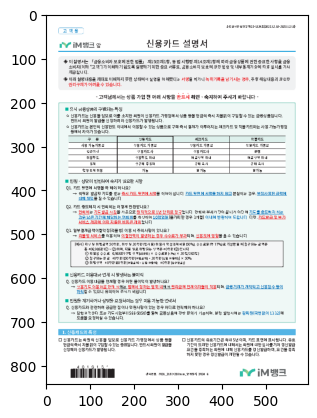

In [7]:
# 이미지 확인
page_img_np = np.array(page_img)
plt.imshow(page_img_np)
plt.show()

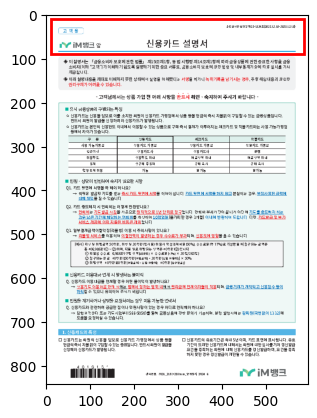

In [8]:
# 이미지 bounding box
bbox = (10, 10, 586, 90)
x0, top, x1, bottom = bbox
width = x1 - x0
height = bottom - top

fig, ax = plt.subplots(1)
ax.imshow(page_img_np)

rect = patches.Rectangle((x0, top), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()

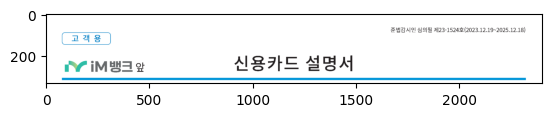

In [9]:
# bounding box에 해당하는 부분
page = pdf_pages[0]
bbox = (10, 10, 586, 90)

page_crop = page.within_bbox(bbox=bbox)
page_crop_img = page_crop.to_image(resolution=300).original
page_crop_img_np = np.array(page_crop_img)

plt.imshow(page_crop_img_np)
plt.show()

In [10]:
# 크롭된 영역에서 텍스트 추출
extracted_text = page_crop.extract_text()

# 추출된 텍스트 출력
print(extracted_text)

준법감시인 심의필 제23-1524호(2023.12.19~2025.12.18)
고 객 용
앞


In [11]:
# # 이미지 저장
# base_path = "./data/card"
# base_name = os.path.basename(data_list[0]).split(".p")[0]
# make_folder = f"{base_path}/image/{base_name}"
# if not os.path.exists(make_folder):
#     os.makedirs(make_folder)
# num = 0
# plt.imsave(f"{make_folder}/{num}.png", page_crop_img_np)

# PDF to Image

In [12]:
print(os.path.basename(data_list[0]))

0_iM Social Worker카드.pdf


In [13]:
save_path = "./data_image/"

for idx in tqdm(range(len(data_list))):
    base_name = os.path.basename(data_list[idx]).split(".p")[0]

    pdf_path = data_list[idx]
    pdf_open = pdfplumber.open(pdf_path)

    pdf_pages = pdf_open.pages

    num = 0

    for page in pdf_pages:
        page_img = page.to_image(resolution=300).original
        page_img_np = np.array(page_img)

        make_folder = f"{save_path}/{base_name}"
        if not os.path.exists(make_folder):
            os.makedirs(make_folder)

        page_num = f"page_{num+1}"
        plt.imsave(f"{make_folder}/{page_num}.jpg", page_img_np)

        num += 1

100%|██████████| 18/18 [00:24<00:00,  1.37s/it]


# EasyOCR

In [14]:
reader = easyocr.Reader(['ko','en'])

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.1% Complete

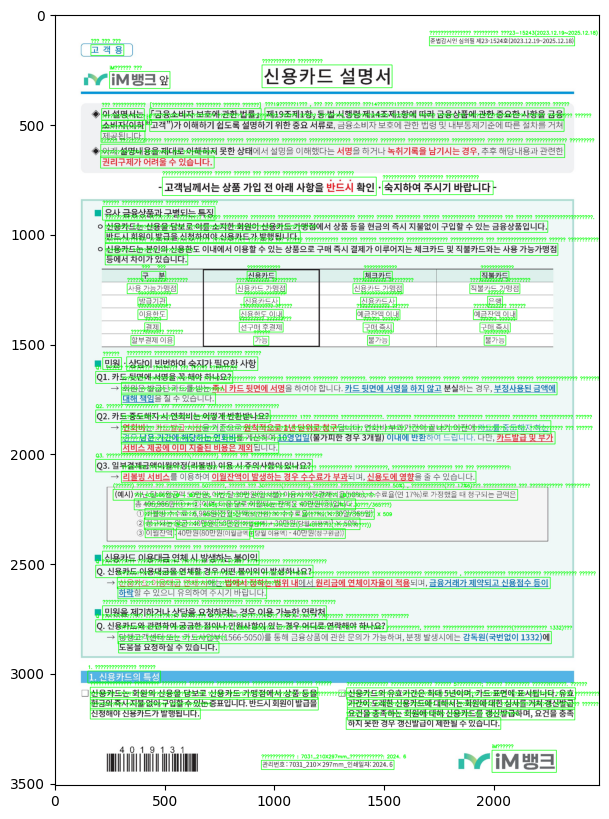

In [22]:
# # cv는 한글이 물음표로 표시됨

# image_path = './data_image/0_iM Social Worker카드/page_1.jpg'

# img = cv2.imread(image_path)

# results = reader.readtext(image_path)

# for result in results:
#     bbox, text, confidence = result
#     # bbox 좌표를 튜플로 변환
#     top_left = tuple(bbox[0])
#     bottom_right = tuple(bbox[2])
    
#     # bounding box를 그리기 (녹색, 두께 2)
#     cv2.rectangle(img, top_left, bottom_right, (0, 255, 0), 2)
    
#     # 텍스트를 이미지에 표시 (녹색, 두께 2, 글자 크기 0.7)
#     cv2.putText(img, text, (top_left[0], top_left[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)

# # 이미지를 matplotlib로 표시
# plt.figure(figsize=(10, 10))
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
# # plt.axis('off')  # 축 제거
# plt.show()

In [26]:
image_path = './data_image/0_iM Social Worker카드/page_1.jpg'
results = reader.readtext(image_path)

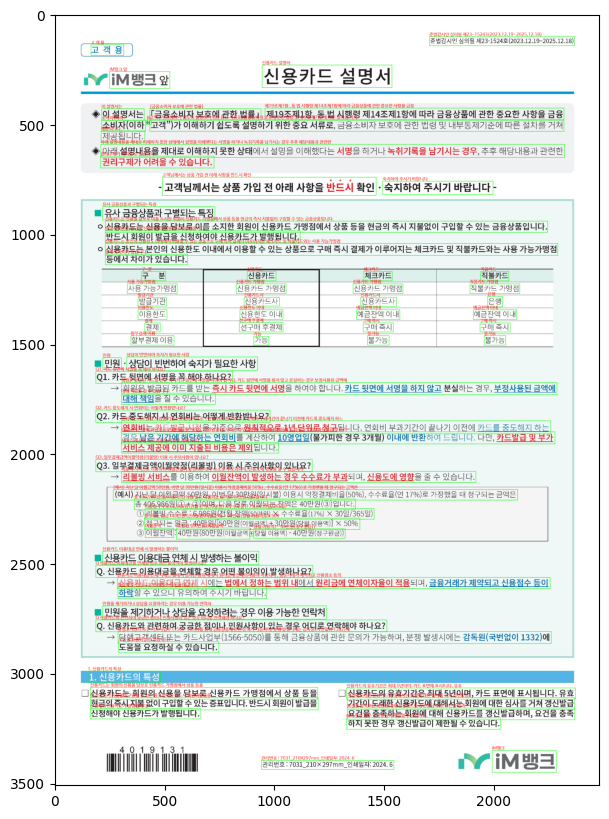

In [25]:
font_path = "/root/2024-IMOPS/pdf-preprocessing/NANUMBARUNGOTHIC.TTF"  # 폰트 경로 설정
font = ImageFont.truetype(font_path, 20)  # 폰트 크기를 적절히 설정

image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

draw = ImageDraw.Draw(image_pil)

# bounding box와 텍스트를 이미지에 그리기
for result in results:
    bbox, text, confidence = result
    # bbox 좌표
    top_left = tuple(bbox[0])
    bottom_right = tuple(bbox[2])
    
    # bounding box 그리기
    draw.rectangle([top_left, bottom_right], outline=(0, 255, 0), width=2)
    
    # 텍스트 그리기 (한글 텍스트를 올바르게 표시)
    draw.text((top_left[0], top_left[1] - 20), text, font=font, fill=(255, 0, 0))

    # Pillow 이미지를 다시 OpenCV 형식으로 변환
image_result = cv2.cvtColor(np.array(image_pil), cv2.COLOR_RGB2BGR)

# 이미지를 matplotlib로 표시
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image_result, cv2.COLOR_BGR2RGB))
# plt.axis('off')  # 축 제거
plt.show()

In [29]:
# 텍스트만 추출
texts = [result[1] for result in results]

# 텍스트 출력
for text in texts:
    print("-----"*10)
    print(text)

--------------------------------------------------
준법감시인 심의필 제23-15243(2023.12.19~2025.12.18)
--------------------------------------------------
고 객 용
--------------------------------------------------
iM방크 앞
--------------------------------------------------
신용카드 설명서
--------------------------------------------------
이 설명서는
--------------------------------------------------
[금움소비자 보호에 관한 법률]
--------------------------------------------------
제19조제1항 , 동 법 시행령 제14조제1항에 따라 금움상품에 관한 중요한 사항울 금웅
--------------------------------------------------
{6
--------------------------------------------------
소비자(이하
--------------------------------------------------
고객")가 이해하기 쉽도록 설명하기 위한 중요 서류로, 금움소비자 보호에 관한 법령 및 내부통제기준에 따른 절차름 거처
--------------------------------------------------
제공되니다.
--------------------------------------------------
아래 설명내용올 제대로 이해하지 못한 상태에서 설명올 이해햇다는 서명올 하거나 녹취기록올 남기시는 경우 주후 해당내용과 관련한
--------------------------------------------------
권리구제가 어려움 수 있습니다.
------------------------